# Predicting a Film's IMDb Rating via Regression and Deep Learning

![hello](images/bazaar.jpg)

## Author: [Patricio Contreras](https://www.linkedin.com/in/pcontreras97/)

## Overview

Having built our multiple linear regression model to predict IMDb ratings, let's now switch to a more advanced type of model and see how well it predicts our response variable:

In [2]:
# import necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import tensorflow as tf

For this model, I'll be using `data/final_df.csv` to train our model.  This is because this dataset has a lot more rows than our other dataset (35,000 vs. 5,000) and our model will perform better if it the training set has a lot more data:

In [3]:
# read in csv and save it as a DataFrame
df = pd.read_csv("data/final_df.csv")
# dimensions of DataFrame
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
# preview df
df.head()

Number of rows: 34787
Number of columns: 9


,title,genre,belongs_to_franchise,production_company,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,Other,1,Walt Disney Studios,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,Adventure,1,Sony Pictures,104.0,17.015539,Fall,Dec,7.0
2,Grumpier Old Men,Romance,1,Other,101.0,11.712900,Fall,Dec,6.7
3,Waiting to Exhale,Comedy,0,Walt Disney Studios,127.0,3.859495,Fall,Dec,6.0
4,Father of the Bride Part II,Comedy,1,Other,106.0,8.387519,Winter,Feb,6.1


As seen by the output above, the csv was read in correctly and the dimensions of this DataFrame are what we expected.

---

## NEURAL NETWORK

For my second model, I have decided to predict `averageRating` using a fully connected (Dense) neural network.  As was the case in building the regression model, this will be an iterative process where we create a baseline model with all predictors and then tune the model in each subsequent iteration.

## Preprocessing

Before we go on to build our neural network, there are some preprocessing steps that need to be taken.

### One Hot Encode `averageRating`

First and foremost, we need to update our response variable.  Neural networks are most commonly used in classification problems and our response variable is continuous.  Therefore, we'll use `to_categorical()` from `tf.keras.utils` to one-hot encode `averageRating` and produce a `(34787, 10)` _Numpy_ ndarray:

In [4]:
from tensorflow.keras.utils import to_categorical

print("Original response variable:")
print(list(df["averageRating"].head()))
print("\n")
print("One hot labels: 10 binary columns, one for each IMDb rating")
averageRating_onehot = to_categorical(df["averageRating"])
print(averageRating_onehot)
print("\n")
print("One hot labels shape:")
print(np.shape(averageRating_onehot))

Original response variable:
[8.3, 7.0, 6.7, 6.0, 6.1]


One hot labels: 10 binary columns, one for each IMDb rating
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


One hot labels shape:
(34787, 10)


### Creating Dummy Variables

We need to convert our categorical variables (`genre`, `production_company`, etc.) into dummy variables so our model knows how to interpret this data.  We'll use `create_dummies()` from `Code/data_cleaning.py` and set the same baseline levels/classes like we did in our previous [notebook](Regression.ipynb):

In [5]:
from Code import data_cleaning as dc
# genre
genre_dummies = dc.create_dummies(df["genre"], "Horror")
# production_company
pc_dummies = dc.create_dummies(df["production_company"], "Other")
# release_season
season_dummies = dc.create_dummies(df["release_season"], "Summer")
# release_month
month_dummies = dc.create_dummies(df["release_month"], "Jan")

### Creating the DataFrame used in the Model

As was the case in the Regression [notebook](Regression.ipynb), we won't alter our original data but rather create different DataFrames for the different models we create.  This way we can always revert back to the clean, original data (if need be) and we don't mix a lot of variables together.

For our baseline model, we'll include _all_ the variables available:

In [6]:
# preview df
df.head()

,title,genre,belongs_to_franchise,production_company,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,Other,1,Walt Disney Studios,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,Adventure,1,Sony Pictures,104.0,17.015539,Fall,Dec,7.0
2,Grumpier Old Men,Romance,1,Other,101.0,11.712900,Fall,Dec,6.7
3,Waiting to Exhale,Comedy,0,Walt Disney Studios,127.0,3.859495,Fall,Dec,6.0
4,Father of the Bride Part II,Comedy,1,Other,106.0,8.387519,Winter,Feb,6.1


In [7]:
# create new DataFrame
X = pd.concat([df, genre_dummies, pc_dummies, season_dummies, 
               month_dummies], axis = 1)
# variables to drop in all models
drop_list = ["title", "genre", "production_company", "release_season", 
             "release_month", "averageRating"]
# drop original categorical variables + response
X.drop(drop_list, axis = 1, inplace = True)

### Train-Validation-Test Split

To start things off, we'll use 70% of the data to train our model, 15% for validation, and 15% to test our model's performance:

In [8]:
random.seed(42)
# training indices - 70%
train_index = np.random.choice(range(len(df)), size = 24351, replace = False)
# validation/test indices
valid_test_index = list(set(range(len(df))) - set(train_index))
# validation indices - 15%
val_index = np.random.choice(valid_test_index, size = 5218, replace = False)
# test indices - 15%
test_index = list(set(valid_test_index) - set(val_index))

X_train = X.iloc[train_index,:].to_numpy()
X_val = X.iloc[val_index,:].to_numpy()
X_test = X.iloc[test_index,:].to_numpy()
y_train = averageRating_onehot[train_index]
y_val = averageRating_onehot[val_index]
y_test = averageRating_onehot[test_index]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", np.shape(y_train))
print("y_val shape:", np.shape(y_val))
print("y_test shape:", np.shape(y_test))

X_train shape: (24351, 32)
X_val shape: (5218, 32)
X_test shape: (5218, 32)
y_train shape: (24351, 10)
y_val shape: (5218, 10)
y_test shape: (5218, 10)


## Baseline Network

For our first model iteration, we'll build a Sequential, fully-connected, 2 layer, neural network with `relu` activation functions.  Since we're dealing with a multiclass problem, a `softmax` activation function is used for our output layer.

In [9]:
from tensorflow.keras import models
from tensorflow.keras import layers

# initialize a sequential model
model = models.Sequential()

# two layers with relu activation
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dense(25, activation = "relu"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling our Baseline Model

When compiling the model, we'll always use `SGD` (stochastic gradient descent) as our optimizer, `categorical_crossentropy` as our loss function, and accuracy as our preferred metric:

In [10]:
# compiling baseline model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Train the Model!

Our baseline model will be trained with a batch size of 20 and the number of epochs will be set to 120:

In [11]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 24351 samples, validate on 5218 samples
Epoch 1/120
24351/24351 [==============================] - 1s 52us/step - loss: 1.6304 - acc: 0.3890 - val_loss: 1.4884 - val_acc: 0.3961
Epoch 2/120
24351/24351 [==============================] - 1s 44us/step - loss: 1.4847 - acc: 0.3933 - val_loss: 1.4885 - val_acc: 0.3959
Epoch 3/120
24351/24351 [==============================] - 1s 47us/step - loss: 1.4789 - acc: 0.3967 - val_loss: 1.4991 - val_acc: 0.3961 - loss: 1.4838 - acc: 
Epoch 4/120
24351/24351 [==============================] - 1s 55us/step - loss: 1.4745 - acc: 0.3977 - val_loss: 1.4664 - val_acc: 0.3961
Epoch 5/120
24351/24351 [==============================] - 1s 54us/step - loss: 1.4737 - acc: 0.3980 - val_loss: 1.4650 - val_acc: 0.4017
Epoch 6/120
24351/24351 [==============================] - 1s 42us/step - loss: 1.4727 - acc: 0.3980 - val_loss: 1.4615 - val_acc: 0.3961
Epoch 7/120
24351/24351 [==============================] - 1s 40us/step - loss: 1.4705 - acc: 0.3983

24351/24351 [==============================] - 1s 40us/step - loss: 1.4424 - acc: 0.4010 - val_loss: 1.4541 - val_acc: 0.3957
Epoch 60/120
24351/24351 [==============================] - 1s 42us/step - loss: 1.4419 - acc: 0.4017 - val_loss: 1.4274 - val_acc: 0.4042
Epoch 61/120
24351/24351 [==============================] - 1s 40us/step - loss: 1.4400 - acc: 0.4005 - val_loss: 1.5770 - val_acc: 0.3735
Epoch 62/120
24351/24351 [==============================] - 1s 43us/step - loss: 1.4417 - acc: 0.4004 - val_loss: 1.4578 - val_acc: 0.3942
Epoch 63/120
24351/24351 [==============================] - 1s 42us/step - loss: 1.4396 - acc: 0.4024 - val_loss: 1.4530 - val_acc: 0.3967
Epoch 64/120
24351/24351 [==============================] - 1s 43us/step - loss: 1.4389 - acc: 0.4002 - val_loss: 1.4452 - val_acc: 0.3957
Epoch 65/120
24351/24351 [==============================] - 1s 42us/step - loss: 1.4399 - acc: 0.4022 - val_loss: 1.4499 - val_acc: 0.3956
Epoch 66/120
24351/24351 [==============

Epoch 118/120
24351/24351 [==============================] - 1s 41us/step - loss: 1.4232 - acc: 0.4042 - val_loss: 1.4315 - val_acc: 0.4143
Epoch 119/120
24351/24351 [==============================] - 1s 40us/step - loss: 1.4206 - acc: 0.4054 - val_loss: 1.4042 - val_acc: 0.4071
Epoch 120/120
24351/24351 [==============================] - 1s 40us/step - loss: 1.4206 - acc: 0.4054 - val_loss: 1.4021 - val_acc: 0.4005


### Plot the Results

Using the data stored in `history`, we'll plot loss vs. epochs and accuracy vs. epochs for both training and validation data:

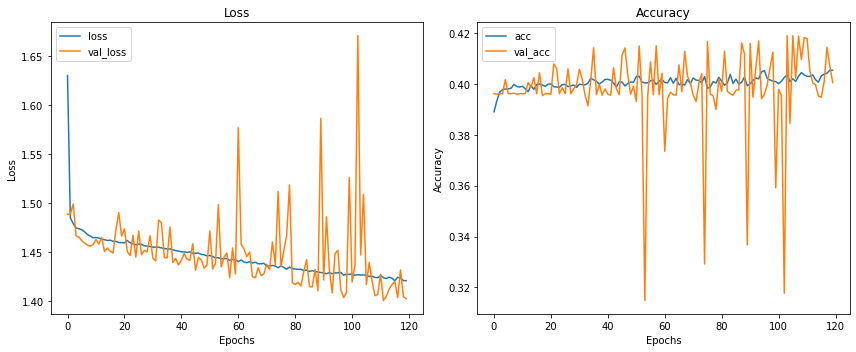

In [12]:
from Code.model_eval import visualise_results

fig, axes = plt.subplots(1, 2, figsize = (12, 5))

visualise_results(history, fig, axes)

The model's validation results spike up and down whereas the training results stay relatively consistent.  Unfortunately the plots also show that the model was not very accurate in predicting an IMDb rating since the maximum accuracy it achieved was 40%.

---

### Evaluate Model Performance

Having checked the model's validation and training results with each epoch, let's evaluate the final model's performance on both the training and testing data:

In [13]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

24351/24351 [==============================] - 0s 12us/step


[1.402321705435939, 0.40367952033477783]

In [14]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

5218/5218 [==============================] - 0s 14us/step


[1.4062932093237588, 0.40111153698735147]

The fact that the model's training and test accuracy are pretty close to one another is a good thing.  It suggests that the model could perform well on new data.  _However_, we cannot ignore the fact that the accuracy results are quite low.

---

### Comments on Baseline Model

As mentioned before, our baseline model did not do well with our multiclass classification problem.  Despite getting fairly close training and testing results, the model's accuracy overall is not the best.  However, this is our first model iteration!  We haven't re-scaled our data, considered other activation functions, or tweaked the model's hyperparameters.

---

## Model 1

### Rescaling our Data

A common step to take when working with neural networks is to re-scale the data.  This makes the learning process a lot easier and efficient since all our numeric features are in the same range.

To do this, we'll use `StandardScaler()` from `sklearn.preprocessing`:

In [15]:
# import MinMaxScaler from SciKit-Learn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# variables to rescale
features = ["runtime", "popularity"]
# fit and transform scaler to data
scaled_data = scaler.fit_transform(df[features])
# create new DataFrame
df_scaled_data = pd.DataFrame(scaled_data, columns = features)
# rename columns appropriately
df_scaled_data.columns = [col+"_scaled" for col in df_scaled_data.columns]
# preview scaled data
df_scaled_data.head()

,runtime_scaled,popularity_scaled
0,-1.074720,4.464713
1,0.338885,3.290137
2,0.154502,2.027140
3,1.752489,0.156594
4,0.461807,1.235091


### Creating the DataFrame

Now that we've re-scaled the data for `runtime` and `popularity`, we'll create a new DataFrame for this model where we'll introduce this new data and remove all the unscaled variables.

In [16]:
# preview data in df
df.head()

,title,genre,belongs_to_franchise,production_company,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,Other,1,Walt Disney Studios,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,Adventure,1,Sony Pictures,104.0,17.015539,Fall,Dec,7.0
2,Grumpier Old Men,Romance,1,Other,101.0,11.712900,Fall,Dec,6.7
3,Waiting to Exhale,Comedy,0,Walt Disney Studios,127.0,3.859495,Fall,Dec,6.0
4,Father of the Bride Part II,Comedy,1,Other,106.0,8.387519,Winter,Feb,6.1


In [17]:
# creating new DataFrame
X = pd.concat([df, df_scaled_data, genre_dummies, 
               pc_dummies, season_dummies, month_dummies], axis = 1)
# dropping original categorical variables + unscaled vars
X.drop(drop_list + ["runtime", "popularity"], axis = 1, inplace = True)

### Train-Validation-Test split

We'll still perform the same train-test split as before.  The dimensions of the training and test data should remain the same.

In [18]:
# train-val-test split with re-scaled data
X_train = X.iloc[train_index,:].to_numpy()
X_val = X.iloc[val_index,:].to_numpy()
X_test = X.iloc[test_index,:].to_numpy()
y_train = averageRating_onehot[train_index]
y_val = averageRating_onehot[val_index]
y_test = averageRating_onehot[test_index]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", np.shape(y_train))
print("y_val shape:", np.shape(y_val))
print("y_test shape:", np.shape(y_test))

X_train shape: (24351, 32)
X_val shape: (5218, 32)
X_test shape: (5218, 32)
y_train shape: (24351, 10)
y_val shape: (5218, 10)
y_test shape: (5218, 10)


### Building the Network

This model will have the same amount of layers, nodes, and activation functions as did our baseline model.  This is because the purpose of this model is to show the effect re-scaling has on our model's performance.

In [19]:
# initialize a sequential model
model = models.Sequential()

# two layers with relu activation
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dense(25, activation = "relu"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling the Model

In [20]:
# compiling baseline model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Training the Model

In [21]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 24351 samples, validate on 5218 samples
Epoch 1/120
24351/24351 [==============================] - 1s 59us/step - loss: 1.5699 - acc: 0.3916 - val_loss: 1.4423 - val_acc: 0.4145
Epoch 2/120
24351/24351 [==============================] - 1s 57us/step - loss: 1.4264 - acc: 0.4196 - val_loss: 1.4062 - val_acc: 0.4341
Epoch 3/120
24351/24351 [==============================] - 1s 46us/step - loss: 1.3980 - acc: 0.4277 - val_loss: 1.3878 - val_acc: 0.4335
Epoch 4/120
24351/24351 [==============================] - 1s 56us/step - loss: 1.3828 - acc: 0.4279 - val_loss: 1.3763 - val_acc: 0.4371
Epoch 5/120
24351/24351 [==============================] - 1s 51us/step - loss: 1.3738 - acc: 0.4304 - val_loss: 1.3700 - val_acc: 0.4339
Epoch 6/120
24351/24351 [==============================] - 1s 48us/step - loss: 1.3664 - acc: 0.4335 - val_loss: 1.3644 - val_acc: 0.4343
Epoch 7/120
24351/24351 [==============================] - 1s 59us/step - loss: 1.3606 - acc: 0.4349 - val_loss: 1.3599 - v

24351/24351 [==============================] - 1s 58us/step - loss: 1.3114 - acc: 0.4450 - val_loss: 1.3358 - val_acc: 0.4454
Epoch 60/120
24351/24351 [==============================] - 1s 57us/step - loss: 1.3114 - acc: 0.4467 - val_loss: 1.3358 - val_acc: 0.4410
Epoch 61/120
24351/24351 [==============================] - 1s 43us/step - loss: 1.3106 - acc: 0.4472 - val_loss: 1.3350 - val_acc: 0.4410
Epoch 62/120
24351/24351 [==============================] - 1s 44us/step - loss: 1.3105 - acc: 0.4473 - val_loss: 1.3391 - val_acc: 0.4421
Epoch 63/120
24351/24351 [==============================] - 1s 46us/step - loss: 1.3102 - acc: 0.4498 - val_loss: 1.3347 - val_acc: 0.4425
Epoch 64/120
24351/24351 [==============================] - 1s 51us/step - loss: 1.3095 - acc: 0.4493 - val_loss: 1.3406 - val_acc: 0.4368
Epoch 65/120
24351/24351 [==============================] - 2s 65us/step - loss: 1.3094 - acc: 0.4463 - val_loss: 1.3364 - val_acc: 0.4442
Epoch 66/120
24351/24351 [==============

Epoch 118/120
24351/24351 [==============================] - 1s 43us/step - loss: 1.2967 - acc: 0.4530 - val_loss: 1.3508 - val_acc: 0.4408
Epoch 119/120
24351/24351 [==============================] - 1s 44us/step - loss: 1.2973 - acc: 0.4533 - val_loss: 1.3415 - val_acc: 0.4369
Epoch 120/120
24351/24351 [==============================] - 1s 43us/step - loss: 1.2971 - acc: 0.4546 - val_loss: 1.3407 - val_acc: 0.4356


### Plot the Results

Having trained our model using the training and validation data, let's plot the model's accuracy and loss with respect to the epoch number:

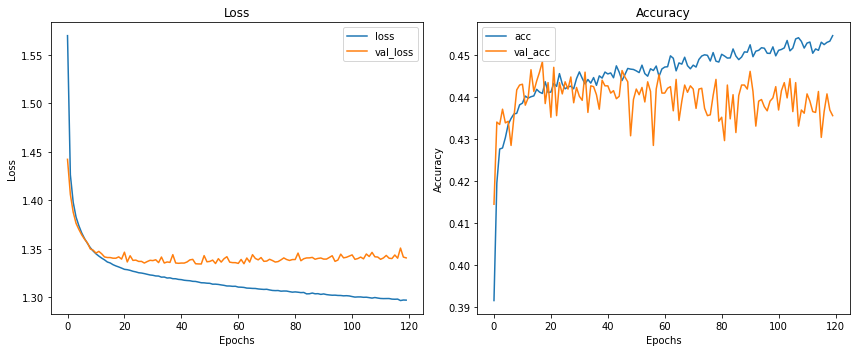

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

visualise_results(history, fig, axes)

These plots look a lot better than our baseline model's results.  Fortunately, both accuracy and epoch change after each epoch, _however_, these plots suggest that there may be overfitting.  The fact that the difference between training and validation results gets bigger with each epoch suggests that the model may be overfitting.

---

### Evaluate Model Performance

Let's check the performance of our model by using our testing data:

In [23]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

24351/24351 [==============================] - 0s 12us/step


[1.2911973567886434, 0.45817420227312905]

In [24]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

5218/5218 [==============================] - 0s 14us/step


[1.3460498955479159, 0.4334994250670755]

The results shown above further suggest that our model might be overfitting to the training data.  It is also important to note that the model is having a hard time learning the features of our data given the poor accuracy result we obtained.

---

### Comments on Model 1

Despite achieving a higher training accuracy and lower loss (compared to our baseline model), this model seems to have slightly overfitted the training data.  Furthermore, our model is struggling with learning the features of our data given that accuracy is around 44%.

## Model 2

### Adding More Data to the Training Set

A common step to take when the neural network is overfitting is to add more data to the training set.  The more data we feed our model, the more it will be able to learn from our training set.  Furthermore, adding more data to the training set will most likely increase the diversity of our data.  This means that our model should be able to learn more features of the data and be less likely to overfit.

That being said, we'll change our train-validation-test split from 70/15/15 to 90/5/5:

In [25]:
# training indices - 90%
train_index = np.random.choice(range(len(df)), size = 31309, replace = False)
# validation/test indices
valid_test_index = list(set(range(len(df))) - set(train_index))
# validation indices - 5%
val_index = np.random.choice(valid_test_index, size = 1739, replace = False)
# test indices - 5%
test_index = list(set(valid_test_index) - set(val_index))

X_train = X.iloc[train_index,:].to_numpy()
X_val = X.iloc[val_index,:].to_numpy()
X_test = X.iloc[test_index,:].to_numpy()
y_train = averageRating_onehot[train_index]
y_val = averageRating_onehot[val_index]
y_test = averageRating_onehot[test_index]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", np.shape(y_train))
print("y_val shape:", np.shape(y_val))
print("y_test shape:", np.shape(y_test))

X_train shape: (31309, 32)
X_val shape: (1739, 32)
X_test shape: (1739, 32)
y_train shape: (31309, 10)
y_val shape: (1739, 10)
y_test shape: (1739, 10)


### Building the Network

Rather than adding a new layer or changing the number of nodes in each layer, we'll keep these settings as they were before.  This way we can measure the effect of adding more data to the training set by comparing the results to our previous model's.

In [26]:
# initialize a sequential model
model = models.Sequential()

# two layers with relu activation
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dense(25, activation = "relu"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling the Model

In [27]:
# compiling model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Training the Model

In [28]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 31309 samples, validate on 1739 samples
Epoch 1/120
31309/31309 [==============================] - 2s 59us/step - loss: 1.5662 - acc: 0.3958 - val_loss: 1.4675 - val_acc: 0.3991
Epoch 2/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.4258 - acc: 0.4221 - val_loss: 1.4292 - val_acc: 0.4186
Epoch 3/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3949 - acc: 0.4293 - val_loss: 1.4041 - val_acc: 0.4244
Epoch 4/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3769 - acc: 0.4315 - val_loss: 1.3911 - val_acc: 0.4198
Epoch 5/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3662 - acc: 0.4328 - val_loss: 1.3792 - val_acc: 0.4209
Epoch 6/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3586 - acc: 0.4342 - val_loss: 1.3738 - val_acc: 0.4244
Epoch 7/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3536 - acc: 0.4366 - val_loss: 1.3740 - v

31309/31309 [==============================] - 1s 41us/step - loss: 1.3141 - acc: 0.4464 - val_loss: 1.3427 - val_acc: 0.4261
Epoch 60/120
31309/31309 [==============================] - 1s 41us/step - loss: 1.3136 - acc: 0.4481 - val_loss: 1.3467 - val_acc: 0.4301
Epoch 61/120
31309/31309 [==============================] - 1s 41us/step - loss: 1.3139 - acc: 0.4476 - val_loss: 1.3431 - val_acc: 0.4204
Epoch 62/120
31309/31309 [==============================] - 1s 41us/step - loss: 1.3135 - acc: 0.4472 - val_loss: 1.3418 - val_acc: 0.4250
Epoch 63/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3130 - acc: 0.4461 - val_loss: 1.3474 - val_acc: 0.4273
Epoch 64/120
31309/31309 [==============================] - 1s 41us/step - loss: 1.3122 - acc: 0.4471 - val_loss: 1.3423 - val_acc: 0.4261
Epoch 65/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3125 - acc: 0.4466 - val_loss: 1.3482 - val_acc: 0.4290
Epoch 66/120
31309/31309 [==============

Epoch 118/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3028 - acc: 0.4526 - val_loss: 1.3590 - val_acc: 0.4227
Epoch 119/120
31309/31309 [==============================] - 1s 41us/step - loss: 1.3026 - acc: 0.4521 - val_loss: 1.3513 - val_acc: 0.4175
Epoch 120/120
31309/31309 [==============================] - 1s 41us/step - loss: 1.3021 - acc: 0.4521 - val_loss: 1.3506 - val_acc: 0.4152


### Plot the Results

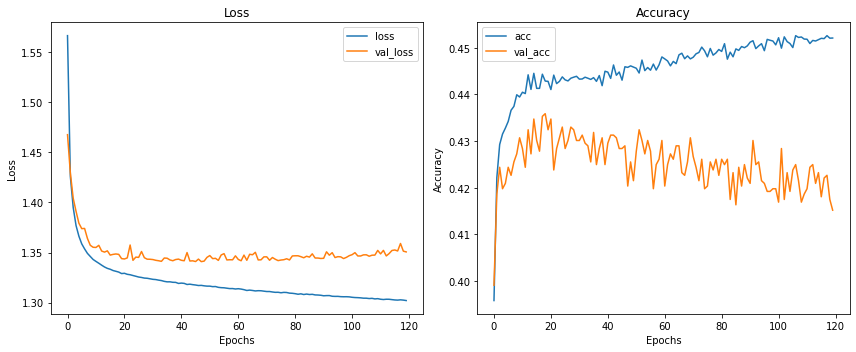

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))

visualise_results(history, fig, axes)

The plots above still show signs of overfitting as the training results improve while the validation results level off.  Furthermore, the overall accuracy of the model hasn't improved much since last time.

---

### Evaluate Model Performance

Finally, let's evaluate the model's performance using our holdout testing set:

In [30]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

31309/31309 [==============================] - 0s 12us/step


[1.2987553945591823, 0.45536427225636417]

In [31]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

1739/1739 [==============================] - 0s 24us/step


[1.3203745715024486, 0.46175963190384745]

While it's expected that a model performs better on the training data than on testing data, the results obtained for this model leads us to believe that it may be overfitting.

### Comments on Model 2

Despite adding more data to our training set, the model still seems to overfit on the training data.  The overall accuracy of the model hasn't really improved given the low value of 45%.

## Model 3

### Reducing the Model's Complexity

Another common step to take when the model is overfitting is to reduce the complexity of the network.  This can be done by either removing layers or reducing the number of nodes in each layer.  This may help our model generalise better to data it hasn't seen before.

### Building the Network

For this model, I'll be removing one of the hidden layers from our network.  This means we'll only have one hidden, dense layer with 50 nodes.  Furthermore, I'll be changing the activation function to `tanh` to see how it affects the model's results:

In [32]:
# initialize a sequential model
model = models.Sequential()

# only one layer with relu activation
model.add(layers.Dense(50, activation = "tanh"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling the Model

In [33]:
# compiling model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Training the Model

In [34]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 31309 samples, validate on 1739 samples
Epoch 1/120
31309/31309 [==============================] - 2s 49us/step - loss: 1.5329 - acc: 0.4061 - val_loss: 1.4384 - val_acc: 0.4100
Epoch 2/120
31309/31309 [==============================] - 1s 41us/step - loss: 1.4073 - acc: 0.4255 - val_loss: 1.4095 - val_acc: 0.4181
Epoch 3/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3889 - acc: 0.4282 - val_loss: 1.3999 - val_acc: 0.4181
Epoch 4/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3786 - acc: 0.4301 - val_loss: 1.3934 - val_acc: 0.4192
Epoch 5/120
31309/31309 [==============================] - 1s 40us/step - loss: 1.3721 - acc: 0.4307 - val_loss: 1.3848 - val_acc: 0.4221
Epoch 6/120
31309/31309 [==============================] - 1s 44us/step - loss: 1.3665 - acc: 0.4325 - val_loss: 1.3798 - val_acc: 0.4215
Epoch 7/120
31309/31309 [==============================] - 1s 40us/step - loss: 1.3622 - acc: 0.4320 - val_loss: 1.3750 - v

Epoch 59/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3231 - acc: 0.4437 - val_loss: 1.3409 - val_acc: 0.4290
Epoch 60/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3232 - acc: 0.4427 - val_loss: 1.3407 - val_acc: 0.4313
Epoch 61/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3225 - acc: 0.4430 - val_loss: 1.3417 - val_acc: 0.4261
Epoch 62/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3227 - acc: 0.4429 - val_loss: 1.3396 - val_acc: 0.4330
Epoch 63/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3224 - acc: 0.4438 - val_loss: 1.3420 - val_acc: 0.4278
Epoch 64/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3222 - acc: 0.4439 - val_loss: 1.3444 - val_acc: 0.4359
Epoch 65/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3218 - acc: 0.4439 - val_loss: 1.3425 - val_acc: 0.4313
Epoch 66/120
31309/31309 [=

Epoch 118/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3155 - acc: 0.4473 - val_loss: 1.3416 - val_acc: 0.4336
Epoch 119/120
31309/31309 [==============================] - 1s 39us/step - loss: 1.3155 - acc: 0.4440 - val_loss: 1.3386 - val_acc: 0.4307
Epoch 120/120
31309/31309 [==============================] - 1s 42us/step - loss: 1.3153 - acc: 0.4463 - val_loss: 1.3415 - val_acc: 0.4353


### Plot the Results

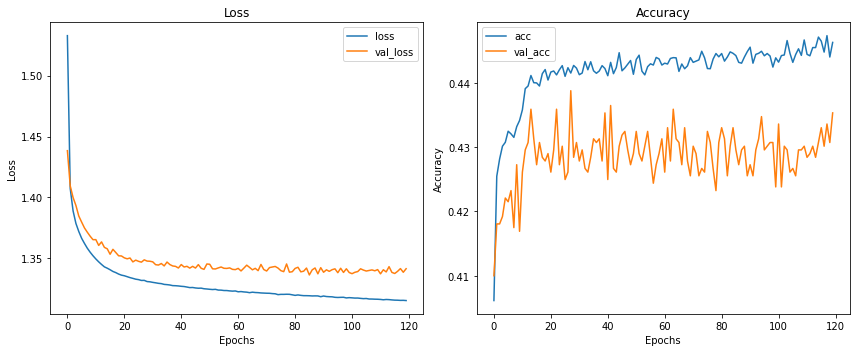

In [35]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))

visualise_results(history, fig, axes)

It seems like reducing the model complexity and changing the activation function shrunk the difference between our training and validation results.  Both plots show the lines fairly close together, however, validation accuracy still doesn't converge and has a lot of variation.  It's still important to note that _overall_ accuracy hasn't really improved and only stayed at around 0.45.

---

### Evaluate Model Performance

Let's evaluate the model's performance using the testing set:

In [36]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

31309/31309 [==============================] - 0s 12us/step


[1.3137850135839897, 0.4460698201818808]

In [37]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

1739/1739 [==============================] - 0s 15us/step


[1.3090910492031105, 0.4709603221269775]

The difference between our training and test results hasn't really changed much since our previous model.

### Comments on Model 3

Removing one layer and changing the activation function seems to have slightly improved our overfitting problem, however, the model's overall accuracy hasn't really changed much since our previous model iterations

## Model 4

### Increasing Model Complexity and Parameter Tuning

So far, our model hasn't been able to pass an accuracy percentage of 50%.  This means that the model is having difficulties learning the data with the current settings.  One technique to improve model performance is by increasing the model's complexity and tune some parameters.

### Building the Network

This network will have 3 hidden layers with 100, 50, and 25 nodes each.  The activation function will change to `tanh` and the output layer will still have an activation function of `softmax`:

In [38]:
# initialize a sequential model
model = models.Sequential()

# three layers with relu activation
model.add(layers.Dense(100, activation = "tanh"))
model.add(layers.Dense(50, activation = "tanh"))
model.add(layers.Dense(25, activation = "tanh"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling the Model

In [39]:
# compiling model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Training the Model

In [40]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 31309 samples, validate on 1739 samples
Epoch 1/120
31309/31309 [==============================] - 2s 64us/step - loss: 1.4829 - acc: 0.4099 - val_loss: 1.4252 - val_acc: 0.4135
Epoch 2/120
31309/31309 [==============================] - 1s 47us/step - loss: 1.3842 - acc: 0.4289 - val_loss: 1.3942 - val_acc: 0.4261
Epoch 3/120
31309/31309 [==============================] - 1s 47us/step - loss: 1.3652 - acc: 0.4336 - val_loss: 1.3854 - val_acc: 0.4221
Epoch 4/120
31309/31309 [==============================] - 1s 47us/step - loss: 1.3553 - acc: 0.4354 - val_loss: 1.3721 - val_acc: 0.4267
Epoch 5/120
31309/31309 [==============================] - 1s 47us/step - loss: 1.3481 - acc: 0.4374 - val_loss: 1.3627 - val_acc: 0.4307
Epoch 6/120
31309/31309 [==============================] - 1s 47us/step - loss: 1.3432 - acc: 0.4388 - val_loss: 1.3589 - val_acc: 0.4255
Epoch 7/120
31309/31309 [==============================] - 1s 47us/step - loss: 1.3399 - acc: 0.4407 - val_loss: 1.3543 - v

31309/31309 [==============================] - 1s 46us/step - loss: 1.3163 - acc: 0.4455 - val_loss: 1.3430 - val_acc: 0.43010s - loss: 1.3188 - a
Epoch 60/120
31309/31309 [==============================] - 1s 47us/step - loss: 1.3162 - acc: 0.4470 - val_loss: 1.3432 - val_acc: 0.4250
Epoch 61/120
31309/31309 [==============================] - 1s 46us/step - loss: 1.3158 - acc: 0.4476 - val_loss: 1.3422 - val_acc: 0.4336
Epoch 62/120
31309/31309 [==============================] - 1s 45us/step - loss: 1.3158 - acc: 0.4470 - val_loss: 1.3429 - val_acc: 0.4296
Epoch 63/120
31309/31309 [==============================] - 1s 46us/step - loss: 1.3154 - acc: 0.4450 - val_loss: 1.3410 - val_acc: 0.4359 - loss: 1.3183 - acc: 0.
Epoch 64/120
31309/31309 [==============================] - 1s 46us/step - loss: 1.3151 - acc: 0.4452 - val_loss: 1.3437 - val_acc: 0.4365
Epoch 65/120
31309/31309 [==============================] - 1s 46us/step - loss: 1.3150 - acc: 0.4459 - val_loss: 1.3406 - val_acc: 0

31309/31309 [==============================] - 1s 46us/step - loss: 1.3043 - acc: 0.4528 - val_loss: 1.3446 - val_acc: 0.42041.3045 - acc: 0.452
Epoch 117/120
31309/31309 [==============================] - 1s 46us/step - loss: 1.3044 - acc: 0.4503 - val_loss: 1.3446 - val_acc: 0.4313
Epoch 118/120
31309/31309 [==============================] - 1s 46us/step - loss: 1.3041 - acc: 0.4508 - val_loss: 1.3464 - val_acc: 0.4238
Epoch 119/120
31309/31309 [==============================] - 1s 46us/step - loss: 1.3034 - acc: 0.4522 - val_loss: 1.3461 - val_acc: 0.4255
Epoch 120/120
31309/31309 [==============================] - 1s 46us/step - loss: 1.3037 - acc: 0.4514 - val_loss: 1.3492 - val_acc: 0.4267


### Plot the Results

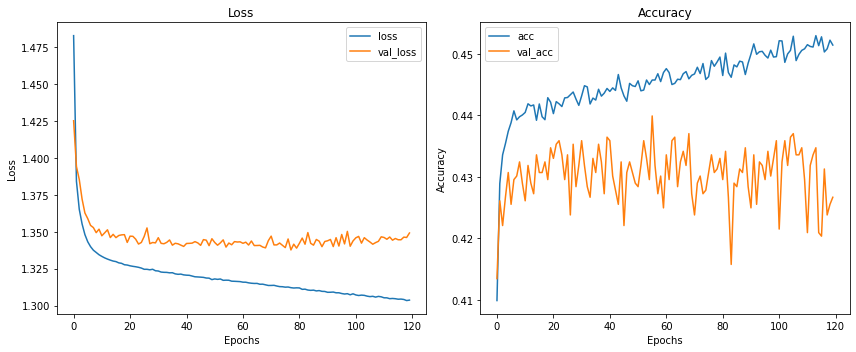

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))

visualise_results(history, fig, axes)

Our model has gotten worse by increasing the complexity.  The difference in training and validation results grew larger and the overall accuracy of the model hasn't changed at all.

---

### Evaluate Model Performance

Let's see how well our model does on our testing data:

In [42]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

31309/31309 [==============================] - 0s 15us/step


[1.3015062764823377, 0.45363952857124956]

In [43]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

1739/1739 [==============================] - 0s 23us/step


[1.3107035044214381, 0.4709603221269775]

The results obtained using the training and testing data aren't much different from previous models' results.  Both still achieve an accuracy of around 44%.

### Comments on Model 4

Unfortunately, the model's accuracy and loss metrics don't seem to change very much by increasing the model complexity.  The overall model accuracy is still relatively low (hasn't even crossed 50%) and the difference between the training results and validation/test results suggest that the model overfits on the training data.

## Using Dataset with Additional Features

Recall that we also have a dataset with 3 additional features stored in `data/final_dfbudget.csv`.  This csv file contains the same features found in our previous dataset + information on a film's budget, revenue, and certification.  The only downside to this is that this dataset has substantially less amount of data.  However, we'll see if adding these 3 additional features will have an effect (or not) on the model's performance.

In [44]:
# read in csv and save it as a DataFrame
df = pd.read_csv("data/final_dfbudget.csv")
# dimensions of DataFrame
print("Number of rows:", df.shape[0])
print("Number of columns:", df.shape[1])
# preview df
df.head()

Number of rows: 5009
Number of columns: 12


,title,budget,revenue,genre,belongs_to_franchise,production_company,cert,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,30000000.0,373554033.0,Animation,1,Walt Disney Studios,G,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,65000000.0,262797249.0,Adventure,1,Sony Pictures,PG,104.0,17.015539,Fall,Dec,7.0
2,Waiting to Exhale,16000000.0,81452156.0,Comedy,0,Walt Disney Studios,R,127.0,3.859495,Fall,Dec,6.0
3,Sudden Death,35000000.0,64350171.0,Action,1,NBCUniversal,R,106.0,5.231580,Fall,Dec,5.8
4,GoldenEye,58000000.0,352194034.0,Adventure,1,Other,PG-13,130.0,14.686036,Fall,Nov,7.2


### Preprocessing: One-hot Encode `averageRating`

In [45]:
print("Original response variable:")
print(list(df["averageRating"].head()))
print("\n")
print("One hot labels: 10 binary columns, one for each IMDb rating")
averageRating_onehot = to_categorical(df["averageRating"])
print(averageRating_onehot)
print("\n")
print("One hot labels shape:")
print(np.shape(averageRating_onehot))

Original response variable:
[8.3, 7.0, 6.0, 5.8, 7.2]


One hot labels: 10 binary columns, one for each IMDb rating
[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


One hot labels shape:
(5009, 10)


### Preprocessing: Creating Dummy Variables

In [46]:
# genre
genre_dummies = dc.create_dummies(df["genre"], "Horror")
# production_company
pc_dummies = dc.create_dummies(df["production_company"], "Other")
# cert
cert_dummies = dc.create_dummies(df["cert"], "G")
# release_season
season_dummies = dc.create_dummies(df["release_season"], "Summer")
# release_month
month_dummies = dc.create_dummies(df["release_month"], "Jan")

### Preprocessing: Rescaling our Data

In [47]:
scaler = StandardScaler()
# variables to rescale
features = ["budget", "revenue", "runtime", "popularity"]
# fit and transform scaler to data
scaled_data = scaler.fit_transform(df[features])
# create new DataFrame
df_scaled_data = pd.DataFrame(scaled_data, columns = features)
# rename columns appropriately
df_scaled_data.columns = [col+"_scaled" for col in df_scaled_data.columns]
# preview scaled data
df_scaled_data.head()

,budget_scaled,revenue_scaled,runtime_scaled,popularity_scaled
0,-0.000104,2.206341,-1.619332,2.314012
1,0.947044,1.368697,-0.185172,1.431681
2,-0.378963,-0.002801,1.248988,-0.922210
3,0.135203,-0.132142,-0.060463,-0.676716
4,0.757615,2.044797,1.436052,1.014884


### Creating the DataFrame

In [48]:
# preview data in df
df.head()

,title,budget,revenue,genre,belongs_to_franchise,production_company,cert,runtime,popularity,release_season,release_month,averageRating
0,Toy Story,30000000.0,373554033.0,Animation,1,Walt Disney Studios,G,81.0,21.946943,Fall,Oct,8.3
1,Jumanji,65000000.0,262797249.0,Adventure,1,Sony Pictures,PG,104.0,17.015539,Fall,Dec,7.0
2,Waiting to Exhale,16000000.0,81452156.0,Comedy,0,Walt Disney Studios,R,127.0,3.859495,Fall,Dec,6.0
3,Sudden Death,35000000.0,64350171.0,Action,1,NBCUniversal,R,106.0,5.231580,Fall,Dec,5.8
4,GoldenEye,58000000.0,352194034.0,Adventure,1,Other,PG-13,130.0,14.686036,Fall,Nov,7.2


In [49]:
# creating new DataFrame
X = pd.concat([df, df_scaled_data, genre_dummies, pc_dummies, 
               cert_dummies, season_dummies, month_dummies], axis = 1)
# dropping original categorical variables + unscaled vars
X.drop(drop_list + ["budget", "revenue", "cert", "runtime", "popularity"], 
       axis = 1, inplace = True)

### Train-Validation-Test split

We'll start off by splitting the DataFrame into 70% training, 15% validation, and 15% testing.  If the model still overfits, we'll assign more data to our training set:

In [50]:
# training indices - 70%
train_index = np.random.choice(range(len(df)), size = 3507, replace = False)
# validation/test indices
valid_test_index = list(set(range(len(df))) - set(train_index))
# validation indices - 15%
val_index = np.random.choice(valid_test_index, size = 751, replace = False)
# test indices - 15%
test_index = list(set(valid_test_index) - set(val_index))

X_train = X.iloc[train_index,:].to_numpy()
X_val = X.iloc[val_index,:].to_numpy()
X_test = X.iloc[test_index,:].to_numpy()
y_train = averageRating_onehot[train_index]
y_val = averageRating_onehot[val_index]
y_test = averageRating_onehot[test_index]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", np.shape(y_train))
print("y_val shape:", np.shape(y_val))
print("y_test shape:", np.shape(y_test))

X_train shape: (3507, 37)
X_val shape: (751, 37)
X_test shape: (751, 37)
y_train shape: (3507, 10)
y_val shape: (751, 10)
y_test shape: (751, 10)


### Building the Network

We'll create our first neural network with this data using the same settings as we started before: 2 dense layers, 50 and 25 nodes, `relu` activation functions, and a dense output layer with 10 nodes and an activation function of `softmax`:

In [51]:
# initialize a sequential model
model = models.Sequential()

# two layers with relu activation
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dense(25, activation = "relu"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling the Model

In [52]:
# compiling model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Training the Model

In [53]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 3507 samples, validate on 751 samples
Epoch 1/120
3507/3507 [==============================] - 1s 144us/step - loss: 2.1728 - acc: 0.2173 - val_loss: 1.8655 - val_acc: 0.3662
Epoch 2/120
3507/3507 [==============================] - 0s 54us/step - loss: 1.6781 - acc: 0.3821 - val_loss: 1.5346 - val_acc: 0.4008
Epoch 3/120
3507/3507 [==============================] - 0s 73us/step - loss: 1.5026 - acc: 0.4069 - val_loss: 1.4543 - val_acc: 0.4168
Epoch 4/120
3507/3507 [==============================] - 0s 70us/step - loss: 1.4481 - acc: 0.4163 - val_loss: 1.4176 - val_acc: 0.4328
Epoch 5/120
3507/3507 [==============================] - 0s 49us/step - loss: 1.4138 - acc: 0.4303 - val_loss: 1.3910 - val_acc: 0.4394
Epoch 6/120
3507/3507 [==============================] - 0s 63us/step - loss: 1.3868 - acc: 0.4346 - val_loss: 1.3694 - val_acc: 0.4447
Epoch 7/120
3507/3507 [==============================] - 0s 51us/step - loss: 1.3640 - acc: 0.4411 - val_loss: 1.3521 - val_acc: 0.4487


3507/3507 [==============================] - 0s 51us/step - loss: 1.1729 - acc: 0.5047 - val_loss: 1.2422 - val_acc: 0.4847
Epoch 61/120
3507/3507 [==============================] - 0s 47us/step - loss: 1.1707 - acc: 0.5124 - val_loss: 1.2414 - val_acc: 0.4687
Epoch 62/120
3507/3507 [==============================] - 0s 46us/step - loss: 1.1696 - acc: 0.5038 - val_loss: 1.2422 - val_acc: 0.4940
Epoch 63/120
3507/3507 [==============================] - 0s 57us/step - loss: 1.1681 - acc: 0.5133 - val_loss: 1.2432 - val_acc: 0.4714
Epoch 64/120
3507/3507 [==============================] - 0s 71us/step - loss: 1.1664 - acc: 0.5061 - val_loss: 1.2455 - val_acc: 0.4780
Epoch 65/120
3507/3507 [==============================] - 0s 47us/step - loss: 1.1660 - acc: 0.5127 - val_loss: 1.2408 - val_acc: 0.4767
Epoch 66/120
3507/3507 [==============================] - 0s 69us/step - loss: 1.1627 - acc: 0.5130 - val_loss: 1.2443 - val_acc: 0.4847
Epoch 67/120
3507/3507 [==============================

Epoch 120/120
3507/3507 [==============================] - 0s 47us/step - loss: 1.0933 - acc: 0.5532 - val_loss: 1.2541 - val_acc: 0.4727


### Plot the Results

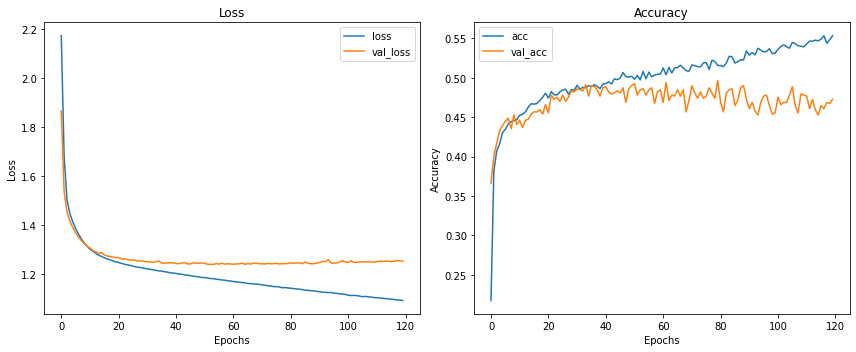

In [54]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))

visualise_results(history, fig, axes)

The model's overall accuracy has improved (compared to our previous models), however, the model still seems to overfit the data.  This is shown by the difference in training and validation results.

---

### Evaluate Model Performance

Now, let's evaluate the model's performance on our test data:

In [55]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

3507/3507 [==============================] - 0s 13us/step


[1.084905933392228, 0.5511833476075291]

In [56]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

751/751 [==============================] - 0s 25us/step


[1.2141760510706234, 0.468708388854597]

The difference in training and testing results is much larger than any of our previous models.  As seen by the plots above, this model really overfit the training data.

### Comments

The difference between our testing and training results is still pretty large and suggests that the model overfit the training data.  Furthermore, the low accuracy results for both sets indicate that the model is still having trouble learning from our data.

---

## Model 1

### Adding a Dropout Layer

One common technique used in neural network tuning to address overfitting is to add a dropout layer.  By adding a droput layer to the model, a random subset of nodes will be ignored during training, which could help our model to generalize better to data it hasn't seen before.

### Building the Network

For this model, we'll be adding a dropout layer with a rate of 30%.  All other settings remain constant:

In [57]:
# initialize a sequential model
model = models.Sequential()

# two layers with relu activation + Dropout
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation = "relu"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling the Model

In [58]:
# compiling model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Training the Model

In [59]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 3507 samples, validate on 751 samples
Epoch 1/120
3507/3507 [==============================] - 1s 163us/step - loss: 2.0667 - acc: 0.3276 - val_loss: 1.7876 - val_acc: 0.3995
Epoch 2/120
3507/3507 [==============================] - 0s 71us/step - loss: 1.6301 - acc: 0.4015 - val_loss: 1.5044 - val_acc: 0.4088
Epoch 3/120
3507/3507 [==============================] - 0s 69us/step - loss: 1.4741 - acc: 0.4243 - val_loss: 1.4353 - val_acc: 0.4328
Epoch 4/120
3507/3507 [==============================] - 0s 55us/step - loss: 1.4299 - acc: 0.4400 - val_loss: 1.4051 - val_acc: 0.4501
Epoch 5/120
3507/3507 [==============================] - 0s 74us/step - loss: 1.4013 - acc: 0.4465 - val_loss: 1.3855 - val_acc: 0.4514
Epoch 6/120
3507/3507 [==============================] - 0s 70us/step - loss: 1.3813 - acc: 0.4445 - val_loss: 1.3692 - val_acc: 0.4474
Epoch 7/120
3507/3507 [==============================] - 0s 53us/step - loss: 1.3632 - acc: 0.4520 - val_loss: 1.3544 - val_acc: 0.4461


3507/3507 [==============================] - 0s 73us/step - loss: 1.1664 - acc: 0.5061 - val_loss: 1.2490 - val_acc: 0.4594
Epoch 61/120
3507/3507 [==============================] - 0s 60us/step - loss: 1.1649 - acc: 0.5090 - val_loss: 1.2488 - val_acc: 0.4594
Epoch 62/120
3507/3507 [==============================] - 0s 51us/step - loss: 1.1623 - acc: 0.5096 - val_loss: 1.2495 - val_acc: 0.4474
Epoch 63/120
3507/3507 [==============================] - 0s 51us/step - loss: 1.1599 - acc: 0.5101 - val_loss: 1.2517 - val_acc: 0.4487
Epoch 64/120
3507/3507 [==============================] - 0s 50us/step - loss: 1.1612 - acc: 0.5104 - val_loss: 1.2491 - val_acc: 0.4527
Epoch 65/120
3507/3507 [==============================] - 0s 50us/step - loss: 1.1591 - acc: 0.5096 - val_loss: 1.2473 - val_acc: 0.4607
Epoch 66/120
3507/3507 [==============================] - 0s 51us/step - loss: 1.1577 - acc: 0.5056 - val_loss: 1.2503 - val_acc: 0.4567
Epoch 67/120
3507/3507 [==============================

Epoch 120/120
3507/3507 [==============================] - 0s 50us/step - loss: 1.0851 - acc: 0.5452 - val_loss: 1.2739 - val_acc: 0.4487


### Plot the Results

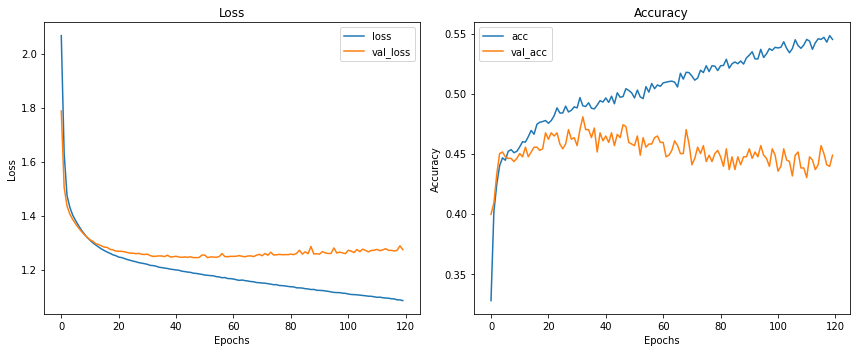

In [60]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))

visualise_results(history, fig, axes)

Looks like adding a dropout layer has improved our overfitting issue a little bit.  The difference in training and validation results has shrunk since our last model.

---

### Evaluate Model Performance

Let's check and see how much the model overfit the training data by using the testing set:

In [61]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

3507/3507 [==============================] - 0s 14us/step


[1.0732173380737533, 0.5540347875847176]

In [62]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

751/751 [==============================] - 0s 20us/step


[1.230104560620299, 0.4687083893704827]

Despite showing signs of improvement at first, the fact that our training and test accuracy differ by 10% is alarming.  The model still overfits on the training data.

### Comments on Model 1

Adding a dropout layer didn't really affect the performance of our model too much.  Training and test results are still substantially different which implies that the model is not generalizable.

---

## Model 2

### Adding more Data to the Training Set + Reducing Model Complexity

Both of these steps should help address the issue of overfitting.  Rather than assign 70% of the data to our training set, we'll assign 90% and leave 10% for validation and testing:

In [63]:
# training indices - 90%
train_index = np.random.choice(range(len(df)), size = 4509, replace = False)
# validation/test indices
valid_test_index = list(set(range(len(df))) - set(train_index))
# validation indices - 5%
val_index = np.random.choice(valid_test_index, size = 250, replace = False)
# test indices - 5%
test_index = list(set(valid_test_index) - set(val_index))

X_train = X.iloc[train_index,:].to_numpy()
X_val = X.iloc[val_index,:].to_numpy()
X_test = X.iloc[test_index,:].to_numpy()
y_train = averageRating_onehot[train_index]
y_val = averageRating_onehot[val_index]
y_test = averageRating_onehot[test_index]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", np.shape(y_train))
print("y_val shape:", np.shape(y_val))
print("y_test shape:", np.shape(y_test))

X_train shape: (4509, 37)
X_val shape: (250, 37)
X_test shape: (250, 37)
y_train shape: (4509, 10)
y_val shape: (250, 10)
y_test shape: (250, 10)


### Building the Network

We'll remove the second hidden layer of this neural network and only have 1 with 50 nodes and `relu` activation function.

In [64]:
# initialize a sequential model
model = models.Sequential()

# two layers with relu activation
model.add(layers.Dense(50, activation = "relu"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling the Model

In [65]:
# compiling model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Training the Model

In [66]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 4509 samples, validate on 250 samples
Epoch 1/120
4509/4509 [==============================] - 1s 124us/step - loss: 1.8068 - acc: 0.3420 - val_loss: 1.5831 - val_acc: 0.4000
Epoch 2/120
4509/4509 [==============================] - 0s 54us/step - loss: 1.4948 - acc: 0.4263 - val_loss: 1.4741 - val_acc: 0.4320
Epoch 3/120
4509/4509 [==============================] - 0s 66us/step - loss: 1.4203 - acc: 0.4342 - val_loss: 1.4281 - val_acc: 0.4600
Epoch 4/120
4509/4509 [==============================] - 0s 53us/step - loss: 1.3811 - acc: 0.4378 - val_loss: 1.3990 - val_acc: 0.4400
Epoch 5/120
4509/4509 [==============================] - 0s 48us/step - loss: 1.3555 - acc: 0.4371 - val_loss: 1.3769 - val_acc: 0.4680
Epoch 6/120
4509/4509 [==============================] - 0s 50us/step - loss: 1.3366 - acc: 0.4440 - val_loss: 1.3583 - val_acc: 0.4640
Epoch 7/120
4509/4509 [==============================] - 0s 51us/step - loss: 1.3231 - acc: 0.4458 - val_loss: 1.3495 - val_acc: 0.4640


4509/4509 [==============================] - 0s 44us/step - loss: 1.1918 - acc: 0.4948 - val_loss: 1.2860 - val_acc: 0.4760
Epoch 61/120
4509/4509 [==============================] - 0s 41us/step - loss: 1.1904 - acc: 0.4919 - val_loss: 1.2838 - val_acc: 0.4800
Epoch 62/120
4509/4509 [==============================] - 0s 41us/step - loss: 1.1900 - acc: 0.4930 - val_loss: 1.2891 - val_acc: 0.4680
Epoch 63/120
4509/4509 [==============================] - 0s 40us/step - loss: 1.1891 - acc: 0.4990 - val_loss: 1.2878 - val_acc: 0.4720
Epoch 64/120
4509/4509 [==============================] - 0s 42us/step - loss: 1.1873 - acc: 0.4994 - val_loss: 1.2909 - val_acc: 0.4680
Epoch 65/120
4509/4509 [==============================] - 0s 42us/step - loss: 1.1864 - acc: 0.4986 - val_loss: 1.2869 - val_acc: 0.4800
Epoch 66/120
4509/4509 [==============================] - 0s 42us/step - loss: 1.1859 - acc: 0.4917 - val_loss: 1.2929 - val_acc: 0.4520
Epoch 67/120
4509/4509 [==============================

Epoch 120/120
4509/4509 [==============================] - 0s 43us/step - loss: 1.1410 - acc: 0.5263 - val_loss: 1.2911 - val_acc: 0.4720


### Plot the Results

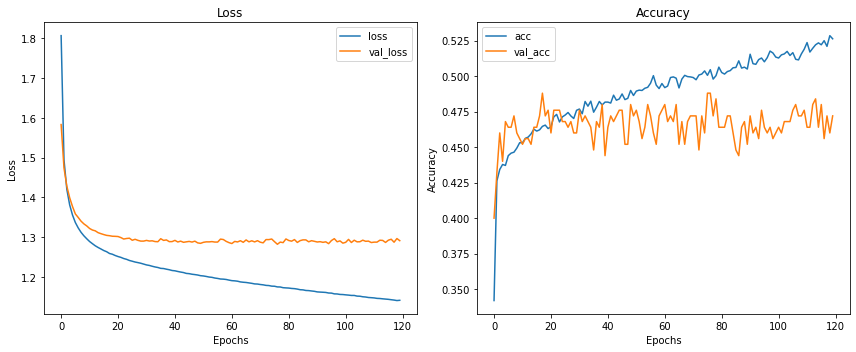

In [67]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))

visualise_results(history, fig, axes)

In this model, the validation results start off pretty well and then worsen while the training results steadily improve over each epoch.

---

### Evaluate Model Performance

Let's evaluate the model performance using our testing set:

In [68]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

4509/4509 [==============================] - 0s 15us/step


[1.1348202594977892, 0.5251718783331013]

In [69]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

250/250 [==============================] - 0s 34us/step


[1.2244697041511536, 0.4840000014305115]

The difference between our model's training and testing results have shrunk.  This is a good sign as it could mean that our model performs equally as well with the training set as with the testing set.

### Comments on Model 2

By assigning more data to our training set and reducing the model complexity, we were able to slightly improve our overfitting problem.  The overall accuracy is better than with the previous dataset, however, this is no better than flipping a coin.

---

## Model 3

### Changing Activation Function

For our last model, I'll keep the network architecture the same (1 hidden layer, 50 nodes, etc.), however, I'll change the activation function to `tanh` instead of `relu`.  This is another common activation function in neural networks and slightly improved our results when working with the previous dataset.

### Building the Network

In [70]:
# initialize a sequential model
model = models.Sequential()

# two layers with relu activation
model.add(layers.Dense(50, activation = "tanh"))

# one layer with softmax activation 
model.add(layers.Dense(10, activation = "softmax"))

### Compiling the Model

In [71]:
# compiling model
model.compile(optimizer = "SGD", 
              loss = "categorical_crossentropy",
              metrics = ["acc"])

### Training the Model

In [72]:
# train the model 
history = model.fit(x = X_train, y = y_train, 
                    batch_size = 20, epochs = 120,
                    validation_data = (X_val, y_val))

Train on 4509 samples, validate on 250 samples
Epoch 1/120
4509/4509 [==============================] - 1s 130us/step - loss: 1.9436 - acc: 0.3200 - val_loss: 1.6227 - val_acc: 0.4000
Epoch 2/120
4509/4509 [==============================] - 0s 44us/step - loss: 1.5010 - acc: 0.4351 - val_loss: 1.4548 - val_acc: 0.4280
Epoch 3/120
4509/4509 [==============================] - 0s 61us/step - loss: 1.4008 - acc: 0.4480 - val_loss: 1.4058 - val_acc: 0.4200
Epoch 4/120
4509/4509 [==============================] - 0s 64us/step - loss: 1.3596 - acc: 0.4495 - val_loss: 1.3808 - val_acc: 0.4360
Epoch 5/120
4509/4509 [==============================] - 0s 52us/step - loss: 1.3354 - acc: 0.4511 - val_loss: 1.3646 - val_acc: 0.4400
Epoch 6/120
4509/4509 [==============================] - 0s 47us/step - loss: 1.3191 - acc: 0.4562 - val_loss: 1.3513 - val_acc: 0.4160
Epoch 7/120
4509/4509 [==============================] - 0s 46us/step - loss: 1.3075 - acc: 0.4582 - val_loss: 1.3423 - val_acc: 0.4320


4509/4509 [==============================] - 0s 43us/step - loss: 1.2084 - acc: 0.4824 - val_loss: 1.3053 - val_acc: 0.4600
Epoch 61/120
4509/4509 [==============================] - 0s 43us/step - loss: 1.2073 - acc: 0.4819 - val_loss: 1.3054 - val_acc: 0.4560
Epoch 62/120
4509/4509 [==============================] - 0s 41us/step - loss: 1.2066 - acc: 0.4841 - val_loss: 1.3030 - val_acc: 0.4640
Epoch 63/120
4509/4509 [==============================] - 0s 43us/step - loss: 1.2053 - acc: 0.4819 - val_loss: 1.3074 - val_acc: 0.4360
Epoch 64/120
4509/4509 [==============================] - 0s 41us/step - loss: 1.2051 - acc: 0.4826 - val_loss: 1.3030 - val_acc: 0.4640
Epoch 65/120
4509/4509 [==============================] - 0s 43us/step - loss: 1.2041 - acc: 0.4868 - val_loss: 1.3025 - val_acc: 0.4600
Epoch 66/120
4509/4509 [==============================] - 0s 43us/step - loss: 1.2034 - acc: 0.4870 - val_loss: 1.3048 - val_acc: 0.4520
Epoch 67/120
4509/4509 [==============================

Epoch 120/120
4509/4509 [==============================] - 0s 43us/step - loss: 1.1667 - acc: 0.4994 - val_loss: 1.3036 - val_acc: 0.4720


### Plot the Results

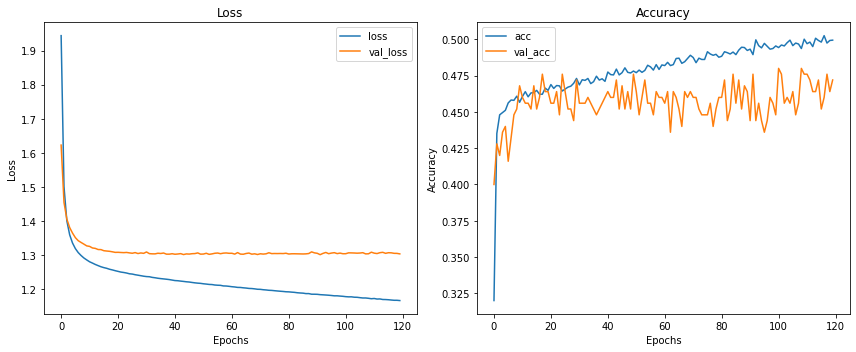

In [73]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))

visualise_results(history, fig, axes)

Looks like changing the activation function had an effect on our results!  The validation results are fairly close to the training results, which suggests that the model didn't overfit this time.

### Evaluate Model Performance

Let's check again how our model holds up to our testing data:

In [74]:
# training results
results_train = model.evaluate(x = X_train, y = y_train)
results_train

4509/4509 [==============================] - 0s 14us/step


[1.1627085130636114, 0.501219782524718]

In [75]:
# test results
results_test = model.evaluate(x = X_test, y = y_test)
results_test

250/250 [==============================] - 0s 35us/step


[1.2104962739944458, 0.4960000019073486]

The model's training and test results are fairly close to one another which further suggests that the model did not overfit on the training data.

### Comments on Model 3

It seems that reducing the complexity of the model and changing the activation function to `tanh` fixed our overfitting problem.  However, the overall accuracy of the model is still, on average, only 50%.

---

## Final Comments

Despite improving our overall accuracy compared to our previous dataset, this neural network did not perform as well as I had imagined.  After re-scaling our data, reducing model complexity, increasing model complexity, changing activation functions, and adding a dropout layer, the overall accuracy of the model was around 50%.

### Limitations

There are a couple of possibilities as to why this model did not perform as well as expected:

- the amount of data in the second dataset was relatively small

- the lack of many numerical features in both datasets

- (from our previous notebooks) the fact that IMDb rating was not really affected when looking at our categorical variables